# Data Analysis 2

First constants are defined:

In [33]:
T_C = 2.27
N = 50*50
transience = 20

Any imports are completed, and the style of the graphs set using `setup_plot.py`

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import setup_plot
from sklearn.preprocessing import MinMaxScaler

## Magnetisation and Energy

Files are read in and the energy and magnetisation plotted.

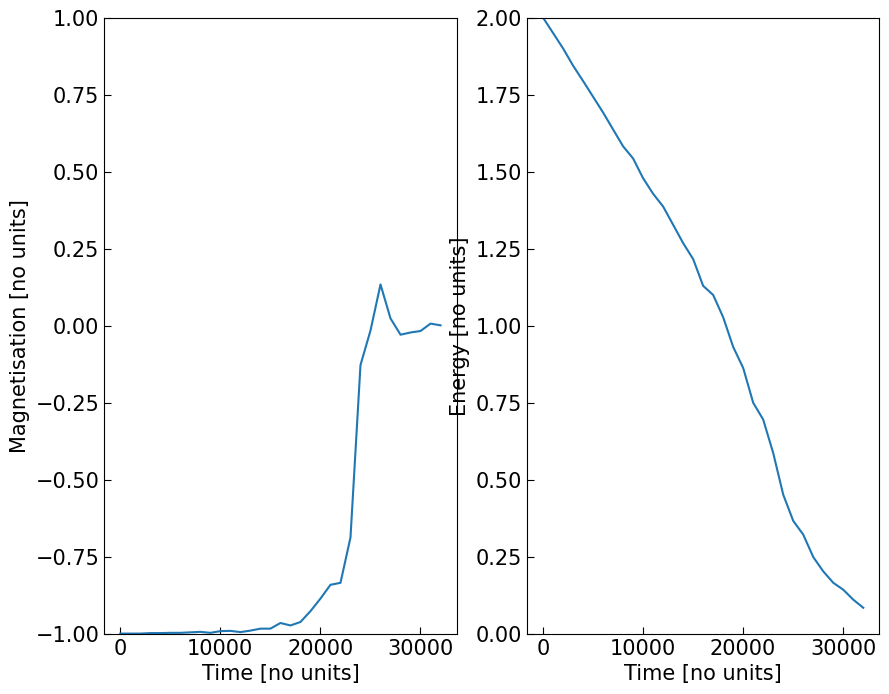

In [35]:
file = "cold_to_hot.csv"

meanfield_data = pd.read_csv("../meanfield.csv")
data = pd.read_csv(file, sep=',', header=0, skiprows=2)
filter = slice(transience,-1,1000)

plt.figure(figsize=[10, 8])

plt.subplot(121)
plt.xlabel("Time [no units]")
plt.ylabel("Magnetisation [no units]")
plt.ylim([-1, 1])
plt.plot(data.time[filter], data.magnetisation[filter])

plt.subplot(122)
plt.xlabel("Time [no units]")
plt.ylabel("Energy [no units]")
plt.ylim([0, 2])
plt.plot(data.time[filter], data.energy[filter])

plt.show()

# data.head()

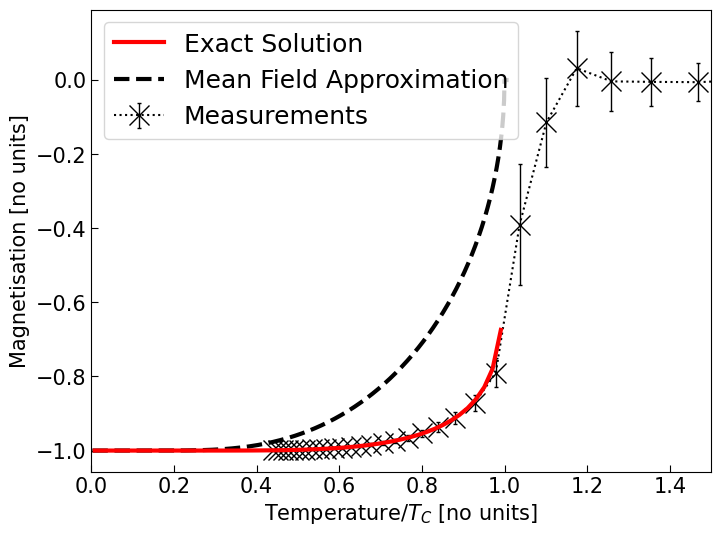

In [36]:
temperature = []
magnetisation = []
magnetisation_err = []

for beta in data['beta'].unique():
    sample_filter = data['beta'] == beta
    sample_data = data[sample_filter]['magnetisation']

    T = 1/beta
    m = np.mean(sample_data)
    temperature.append(T/T_C)
    magnetisation.append(m)
    magnetisation_err.append(np.std(sample_data))

T = np.linspace(0.02, 2.25, 50)
m = - np.power(
    1 - 1/(
        np.power(np.sinh(T_C/T * np.log(2.414)),4)
    ),
    0.125
)

plt.figure(figsize=[8, 6])

plt.xlabel("Temperature$/T_C$ [no units]")
plt.ylabel("Magnetisation [no units]")

plt.errorbar(temperature, magnetisation, magnetisation_err,
             None, ':x', elinewidth=1.0, capsize=1.5,
             markersize=15.0,
             color="black", zorder=1,
             label="Measurements")
plt.plot(T/T_C, m,
         '-',
         color="red",
         linewidth= 3.0, zorder=3,
         label="Exact Solution")
plt.plot(meanfield_data['T/T_C'], -meanfield_data['m'],
         "--",
         color="black", linewidth=3.0, zorder=2,
         label="Mean Field Approximation")

plt.xlim([0, 1.5])

plt.legend()
plt.savefig("comparison.png", dpi=300, pad_inches=0, bbox_inches="tight")
plt.show()

## Heat Capacity

In [37]:
def convert_data(filename):
    output = pd.DataFrame({}, columns=[
        "temperature", "magnetisation", "energy",
        "unc_mag", "unc_energy",
        "var_mag", "var_energy",
        "av_cor1", "av_cor2", "av_cor3"
    ])

    input = pd.read_csv(filename, sep=',', header=0, skiprows=2)

    for beta in data['beta'].unique():
        sample_filter = input['beta'] == beta
        sample = input[sample_filter]

        output = output.append({
            "temperature": 1/beta,

            "magnetisation": np.mean(sample['magnetisation']),
            "unc_mag": np.std(sample['magnetisation'][0:-1:10]),

            "energy": np.mean(sample['energy']),
            "unc_energy": np.std(sample['energy'][0:-1:10]),

            "var_mag": np.var(sample['magnetisation']),
            "var_energy":np.var(sample['energy']),

            "av_cor1": np.mean(sample['cor1'][0:-1:1]),
            "av_cor2":np.mean(sample['cor2'][0:-1:1]),
            "av_cor3":np.mean(sample['cor3'][0:-1:1]),

            "unc_av_cor1": np.std(sample['cor1'][0:-1:1]),
            "unc_av_cor2":np.std(sample['cor2'][0:-1:1]),
            "unc_av_cor3":np.std(sample['cor3'][0:-1:1])

        },ignore_index=True)

    output = output.dropna(0)
    return output

In [38]:
cooling = convert_data("hot_to_cold.csv")
heating = convert_data("cold_to_hot.csv")

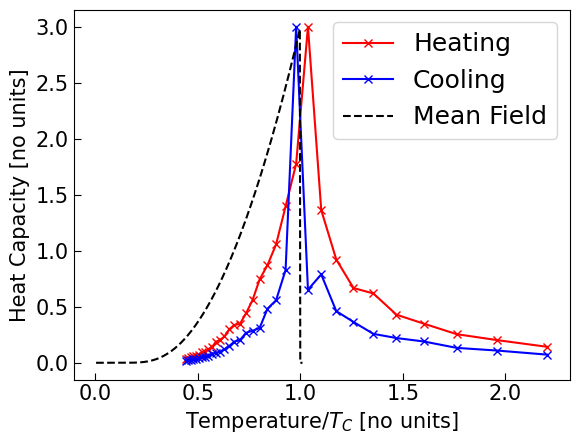

In [39]:
# HEAT CAPACITIES

plt.figure()

plt.xlabel("Temperature$/T_C$ [no units]")
plt.ylabel("Heat Capacity [no units]")

plt.plot(
    heating['temperature']/T_C,
    heating['var_energy'] * 3/max(heating['var_energy']),
    '-x', label="Heating", color="red")
plt.plot(
    cooling['temperature']/T_C,
    cooling['var_energy'] * 3/max(cooling['var_energy']),
    '-x', label="Cooling", color="blue")
plt.plot(meanfield_data['T/T_C'],
         meanfield_data['c'],
         "--", label="Mean Field", color="black")

# plt.xlim([0, 2])
plt.legend()
plt.show()

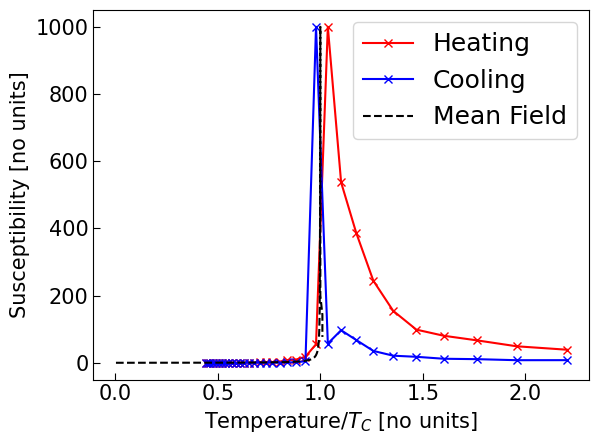

In [40]:
# SUSCEPTIBILITIES

plt.figure()

plt.xlabel("Temperature$/T_C$ [no units]")
plt.ylabel("Susceptibility [no units]")

plt.plot(
    heating['temperature']/T_C,
    heating['var_mag'] * 1000/max(heating['var_mag']),
    '-x', label="Heating", color="red")
plt.plot(
    cooling['temperature']/T_C,
    cooling['var_mag'] * 1000/max(cooling['var_mag']),
    '-x', label="Cooling", color="blue")
plt.plot(meanfield_data['T/T_C'],
         meanfield_data['chi'],
         "--", label="Mean Field", color="black")

# plt.xlim([0, 2])
plt.legend()
plt.show()


In [41]:
from scipy.signal import find_peaks

def get_peak(x, y):
    # x = variable['temperature']
    # y = variable['var_mag']
    t = 0.25 * (max(y)-min(y))

    peaks, _ = find_peaks(y, threshold=t)
    return x[peaks]

peaks = [
    get_peak(heating['temperature'], heating['var_mag']),
    get_peak(cooling['temperature'], cooling['var_mag']),
    get_peak(cooling['temperature'], cooling['var_energy']),
    get_peak(heating['temperature'], heating['var_energy']),
    get_peak(meanfield_data['T/T_C']*T_C, meanfield_data['chi'])
]

print(np.mean(peaks), np.std(peaks))
# print(peaks[2])

2.284065359477124 0.05888079130125939


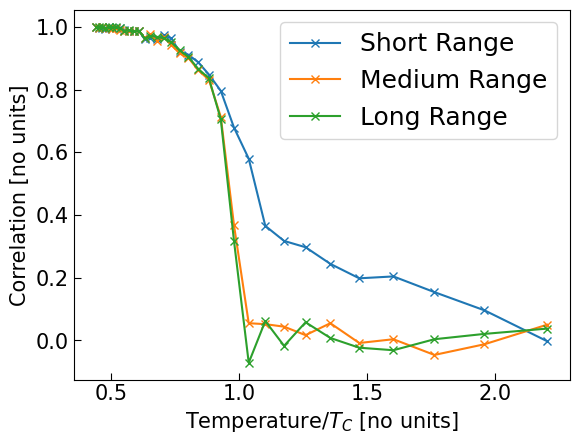

In [42]:
# SUSCEPTIBILITIES

temperature = np.mean([heating['temperature'], cooling['temperature']], axis=0)
av_cor1 = np.mean([heating['av_cor1'], cooling['av_cor1']], axis=0)
av_cor2 = np.mean([heating['av_cor2'], cooling['av_cor2']], axis=0)
av_cor3 = np.mean([heating['av_cor3'], cooling['av_cor3']], axis=0)

plt.figure()

plt.xlabel("Temperature$/T_C$ [no units]")
plt.ylabel("Correlation [no units]")

plt.plot(
    temperature/T_C,
    av_cor1,
    '-x', label="Short Range")
plt.plot(
    temperature/T_C,
    av_cor2,
    '-x', label="Medium Range")
plt.plot(
    temperature/T_C,
    av_cor3,
    '-x', label="Long Range")

plt.legend()
plt.show()

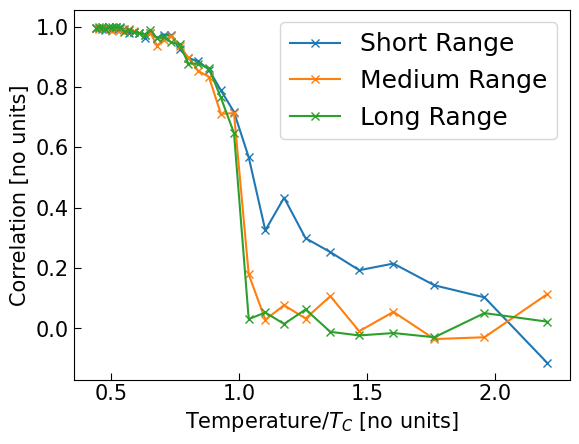

In [43]:
plt.figure()

plt.xlabel("Temperature$/T_C$ [no units]")
plt.ylabel("Correlation [no units]")

plt.plot(
    heating['temperature']/T_C,
    heating['av_cor1'],
    '-x', label="Short Range")
plt.plot(
    heating['temperature']/T_C,
    heating['av_cor2'],
    '-x', label="Medium Range")
plt.plot(
    heating['temperature']/T_C,
    heating['av_cor3'],
    '-x', label="Long Range")

# plt.xlim([0, 2])
# plt.ylim([0, 1])
plt.legend()
plt.show()

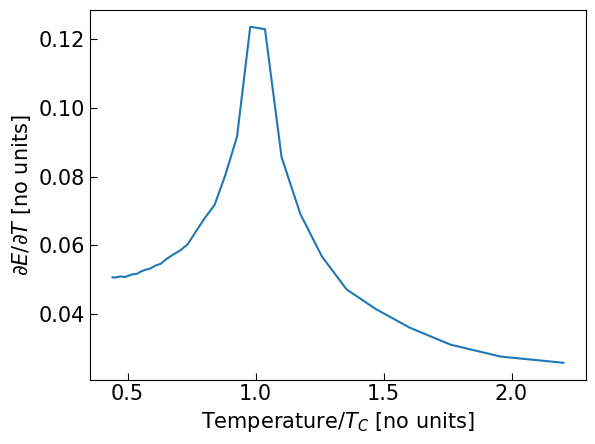

In [44]:
heat_capacity_numerical = np.gradient(heating['energy'])

plt.xlabel("Temperature$/T_C$ [no units]")
plt.ylabel("$\partial E / \partial T$ [no units]")
plt.plot(heating['temperature']/T_C, -heat_capacity_numerical)

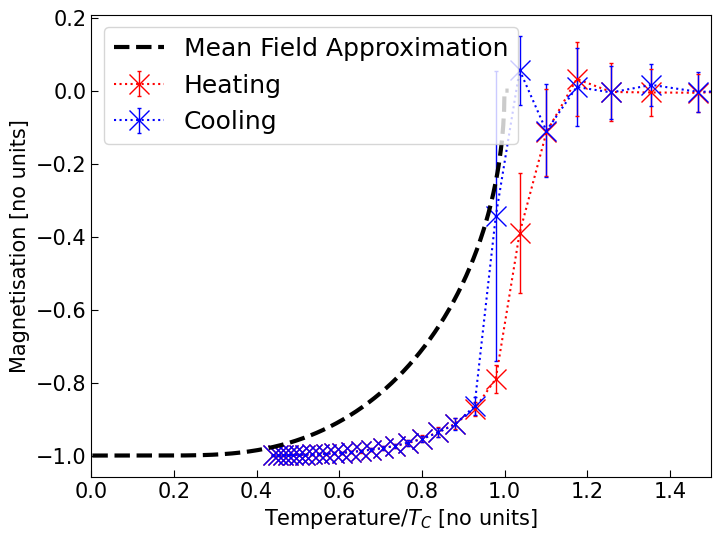

In [45]:
plt.figure(figsize=[8, 6])

plt.xlabel("Temperature$/T_C$ [no units]")
plt.ylabel("Magnetisation [no units]")

plt.errorbar(heating['temperature']/T_C, heating['magnetisation'], heating['unc_mag'],
             None, ':x', elinewidth=1.0, capsize=1.5,
             markersize=15.0,
             color="red", zorder=1,
             label="Heating")
plt.errorbar(cooling['temperature']/T_C, -cooling['magnetisation'], cooling['unc_mag'],
             None, ':x', elinewidth=1.0, capsize=1.5,
             markersize=15.0,
             color="blue", zorder=1,
             label="Cooling")
plt.plot(meanfield_data['T/T_C'], -meanfield_data['m'],
         "--",
         color="black", linewidth=3.0, zorder=2,
         label="Mean Field Approximation")

plt.xlim([0, 1.5])

plt.legend()
# plt.savefig("comparison.png", dpi=300, pad_inches=0, bbox_inches="tight")
plt.show()